# Summary

* ADD LATER
* ADD LATER
* ADD LATER

# Estimation

In [1]:
import pymc3 as pm
import arviz as az
import pandas as pd
import numpy as np
from datetime import datetime
import os

exec(open('../env_vars.py').read())
dir_data = os.environ['dir_data']
dir_picklejar = os.environ['dir_picklejar']

Only self-report data will be used to estimate time between events for now.

In [2]:
data_selfreport = pd.read_csv(os.path.join(os.path.realpath(dir_data), 'work_with_datapoints.csv'))
use_this_data = data_selfreport

Let's define the distribution of censored data.

In [3]:
def exponential_log_complementary_cdf(x, lam):
    ''' log complementary CDF of exponential distribution '''
    return -lam*x

Let's pull out variables that will be used in all models.

In [4]:
censored = use_this_data['censored'].values.astype(bool)
time_to_next_event = use_this_data['time_to_next_event'].values.astype(float)
is_post_quit = use_this_data['is_post_quit'].values.astype(float)

Let's pull out features we have constructed.

In [5]:
# Features applicable to pre- and post-quit periods
day_within_period = use_this_data['day_within_period'].values.astype(float)
hours_since_previous_sr_within_day = use_this_data['hours_since_previous_sr_within_day'].values.astype(float)
hours_since_previous_sr_within_period = use_this_data['hours_since_previous_sr_within_period'].values.astype(float)
is_first_sr_within_day = use_this_data['is_first_sr_within_day'].values.astype(float)
is_first_sr_within_period = use_this_data['is_first_sr_within_period'].values.astype(float)
order_within_day = use_this_data['order_within_day'].values.astype(float)
order_within_period = use_this_data['order_within_period'].values.astype(float)
hours_since_start_of_study = use_this_data['hours_since_start_of_study'].values.astype(float)
hours_since_start_of_period = use_this_data['hours_since_start_of_period'].values.astype(float)
hour_of_day = use_this_data['hour_of_day'].values.astype(float)
sleep = use_this_data['sleep'].values.astype(float)  # 1=if between 1am to 6am, 0=outside of this time

# Features applicable only to the post-quit period
is_within24hours_quit = use_this_data['is_within24hours_quit'].values.astype(float)
is_within48hours_quit = use_this_data['is_within48hours_quit'].values.astype(float)
is_within72hours_quit = use_this_data['is_within72hours_quit'].values.astype(float)

## Model 1

In [6]:
with pm.Model() as model:
    # -------------------------------------------------------------------------
    # Priors
    # -------------------------------------------------------------------------
    beta_prequit = pm.Normal('beta_prequit', mu=0, sd=10)
    beta_postquit = pm.Normal('beta_postquit', mu=0, sd=10)
    beta_prequit_day = pm.Normal('beta_prequit_day', mu=0, sd=10)
    beta_postquit_day = pm.Normal('beta_postquit_day', mu=0, sd=10)
    # -------------------------------------------------------------------------
    # Likelihood
    # -------------------------------------------------------------------------
    loglamb_observed = (
        beta_prequit*(1-is_post_quit[~censored]) + beta_prequit_day*day_within_period[~censored]*(1-is_post_quit[~censored])
        + beta_postquit*is_post_quit[~censored] + beta_postquit_day*day_within_period[~censored]*is_post_quit[~censored]
        )

    lamb_observed = np.exp(loglamb_observed)

    Y_hat_observed = pm.Exponential('Y_hat_observed', lam = lamb_observed, observed=time_to_next_event[~censored])

    loglamb_censored = (
        beta_prequit*(1-is_post_quit[censored]) + beta_prequit_day*day_within_period[censored]*(1-is_post_quit[censored]) 
        + beta_postquit*is_post_quit[censored] + beta_postquit_day*day_within_period[censored]*is_post_quit[censored]
    )

    lamb_censored = np.exp(loglamb_censored)

    Y_hat_censored = pm.Potential('Y_hat_censored', exponential_log_complementary_cdf(x = time_to_next_event[censored], lam = lamb_censored))

# Sample from posterior distribution
with model:
    posterior_samples = pm.sample(draws=1000, tune=1000, cores=1, init='adapt_diag', target_accept=0.90, max_treedepth=50)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_postquit_day, beta_prequit_day, beta_postquit, beta_prequit]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 515.26it/s]


In [7]:
# Calculate 95% credible interval
model_summary_logscale = az.summary(posterior_samples, credible_interval=.95)
model_summary_logscale = model_summary_logscale[['mean','hpd_2.5%','hpd_97.5%']]
model_summary_logscale

,mean,hpd_2.5%,hpd_97.5%
beta_prequit,-1.724,-1.819,-1.620
beta_postquit,-3.493,-3.622,-3.370
beta_prequit_day,-0.362,-0.436,-0.293
beta_postquit_day,0.207,0.186,0.227


In [8]:
summary_expscale = {'mean': [np.mean(np.exp(posterior_samples['beta_prequit_day'])), np.mean(np.exp(posterior_samples['beta_postquit_day']))],
                    'LB': [np.quantile(np.exp(posterior_samples['beta_prequit_day']), q=.125), np.quantile(np.exp(posterior_samples['beta_postquit_day']), q=.125)],
                    'UB': [np.quantile(np.exp(posterior_samples['beta_prequit_day']), q=.975), np.quantile(np.exp(posterior_samples['beta_postquit_day']), q=.975)]}

summary_expscale = pd.DataFrame(summary_expscale)
summary_expscale.index = ['exp_beta_prequit_day','exp_beta_postquit_day']
summary_expscale

,mean,LB,UB
exp_beta_prequit_day,0.696823,0.668354,0.746416
exp_beta_postquit_day,1.230090,1.214710,1.255201


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000217000FDD88>,
      dtype=object)

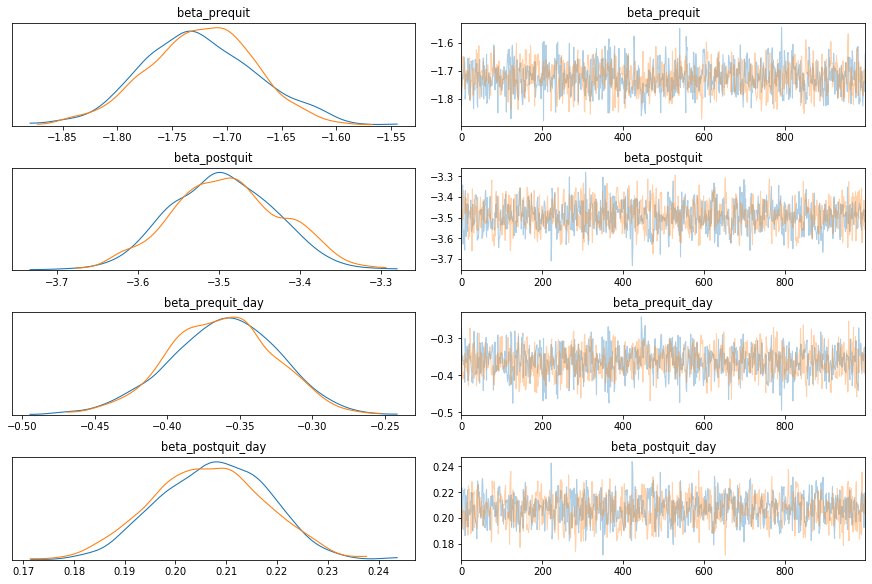

In [9]:
pm.traceplot(posterior_samples)

In [10]:
# Remove variable from workspace
del model, posterior_samples, model_summary_logscale

## Model 2

In [11]:
feature1 = hours_since_previous_sr_within_period

In [12]:
with pm.Model() as model:
    # -------------------------------------------------------------------------
    # Priors
    # -------------------------------------------------------------------------
    beta_prequit = pm.Normal('beta_prequit', mu=0, sd=10)
    beta_postquit = pm.Normal('beta_postquit', mu=0, sd=10)
    beta_prequit_feature1 = pm.Normal('beta_prequit_feature1', mu=0, sd=10)
    beta_postquit_feature1 = pm.Normal('beta_postquit_feature1', mu=0, sd=10)


    # -------------------------------------------------------------------------
    # Likelihood
    # -------------------------------------------------------------------------
    loglamb_observed = (
        beta_prequit*(1-is_post_quit[~censored]) + beta_postquit*is_post_quit[~censored]
        )

    loglamb_observed_features = (
        beta_prequit_feature1*feature1[~censored]*(1-is_post_quit[~censored]) +
        beta_postquit_feature1*feature1[~censored]*is_post_quit[~censored]
    )

    lamb_observed = np.exp(loglamb_observed + loglamb_observed_features)

    Y_hat_observed = pm.Exponential('Y_hat_observed', lam = lamb_observed, observed=time_to_next_event[~censored])

    loglamb_censored = (
        beta_prequit*(1-is_post_quit[censored]) + beta_postquit*is_post_quit[censored]
    )
    
    loglamb_censored_features = (
        beta_prequit_feature1*feature1[censored]*(1-is_post_quit[censored]) +
        beta_postquit_feature1*feature1[censored]*is_post_quit[censored]
    )

    lamb_censored = np.exp(loglamb_censored + loglamb_censored_features)

    Y_hat_censored = pm.Potential('Y_hat_censored', exponential_log_complementary_cdf(x = time_to_next_event[censored], lam = lamb_censored))

#%%
# Sample from posterior distribution
with model:
    posterior_samples = pm.sample(draws=1000, tune=1000, cores=1, init='adapt_diag', target_accept=0.90, max_treedepth=50)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_postquit_feature1, beta_prequit_feature1, beta_postquit, beta_prequit]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 612.54it/s]


In [13]:
model_summary_logscale = az.summary(posterior_samples, credible_interval=.95)
model_summary_logscale = model_summary_logscale[['mean','hpd_2.5%','hpd_97.5%']]
model_summary_logscale

,mean,hpd_2.5%,hpd_97.5%
beta_prequit,-1.942,-2.019,-1.864
beta_postquit,-2.197,-2.277,-2.108
beta_prequit_feature1,-0.047,-0.061,-0.034
beta_postquit_feature1,-0.045,-0.052,-0.037


In [14]:
posterior_samples_expscale_prequit_feature1 = np.exp(posterior_samples['beta_prequit_feature1'])
posterior_samples_expscale_postquit_feature1 = np.exp(posterior_samples['beta_postquit_feature1'])

model_summary_expscale = {'mean': [np.mean(posterior_samples_expscale_prequit_feature1), np.mean(posterior_samples_expscale_postquit_feature1)],
                          'LB': [np.quantile(posterior_samples_expscale_prequit_feature1, q=.125), np.quantile(posterior_samples_expscale_postquit_feature1, q=.125)],
                          'UB': [np.quantile(posterior_samples_expscale_prequit_feature1, q=.975), np.quantile(posterior_samples_expscale_postquit_feature1, q=.975)]}

model_summary_expscale = pd.DataFrame(model_summary_expscale)
model_summary_expscale.index = ['exp_beta_prequit_feature1', 'exp_beta_postquit_feature1']
model_summary_expscale

,mean,LB,UB
exp_beta_prequit_feature1,0.953719,0.945890,0.965893
exp_beta_postquit_feature1,0.956463,0.952216,0.963549


In [15]:
diff_prepost_feature1 = posterior_samples['beta_postquit_feature1'] - posterior_samples['beta_prequit_feature1']
exp_diff_prepost_feature1 = np.exp(diff_prepost_feature1)

diff_summary_expscale = {'mean': [np.mean(exp_diff_prepost_feature1)],
                          'LB': [np.quantile(exp_diff_prepost_feature1, q=.125)],
                          'UB': [np.quantile(exp_diff_prepost_feature1, q=.975)]}

diff_summary_expscale = pd.DataFrame(diff_summary_expscale)
diff_summary_expscale.index = ['exp_diff_prepost_feature1']
diff_summary_expscale

,mean,LB,UB
exp_diff_prepost_feature1,1.002926,0.993828,1.019334


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002177E084748>,
      dtype=object)

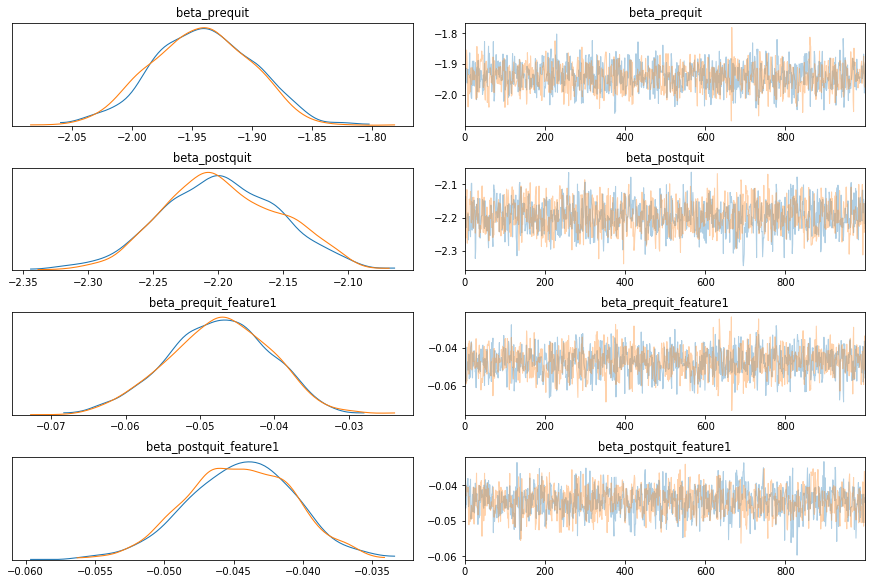

In [16]:
pm.traceplot(posterior_samples)

## Model 3

In [17]:
feature1 = is_within48hours_quit
feature2 = hours_since_previous_sr_within_period

In [18]:
with pm.Model() as model:
    # -------------------------------------------------------------------------
    # Priors
    # -------------------------------------------------------------------------
    beta_prequit = pm.Normal('beta_prequit', mu=0, sd=10)
    beta_postquit = pm.Normal('beta_postquit', mu=0, sd=10)
    beta_postquit_feature1 = pm.Normal('beta_postquit_feature1', mu=0, sd=10)
    beta_prequit_feature2 = pm.Normal('beta_prequit_feature2', mu=0, sd=10)
    beta_postquit_feature2 = pm.Normal('beta_postquit_feature2', mu=0, sd=10)
    beta_postquit_feature_product = pm.Normal('beta_postquit_feature_product', mu=0, sd=10)

    # -------------------------------------------------------------------------
    # Likelihood
    # -------------------------------------------------------------------------
    loglamb_observed = (
        beta_prequit*(1-is_post_quit[~censored]) + beta_postquit*is_post_quit[~censored] 
        )

    loglamb_observed_features1 = (
        beta_postquit_feature1*feature1[~censored]*is_post_quit[~censored] +
        beta_prequit_feature2*feature2[~censored]*(1-is_post_quit[~censored]) +
        beta_postquit_feature2*feature2[~censored]*is_post_quit[~censored] +
        beta_postquit_feature_product*feature1[~censored]*feature2[~censored]*is_post_quit[~censored]
    )

    lamb_observed = np.exp(loglamb_observed + loglamb_observed_features1)

    Y_hat_observed = pm.Exponential('Y_hat_observed', lam = lamb_observed, observed=time_to_next_event[~censored])

    loglamb_censored = (
        beta_prequit*(1-is_post_quit[censored]) + beta_postquit*is_post_quit[censored] 
    )
    
    loglamb_censored_features1 = (
        beta_postquit_feature1*feature1[censored]*is_post_quit[censored] +
        beta_prequit_feature2*feature2[censored]*(1-is_post_quit[censored]) +
        beta_postquit_feature2*feature2[censored]*is_post_quit[censored] +
        beta_postquit_feature_product*feature1[censored]*feature2[censored]*is_post_quit[censored]
    )

    lamb_censored = np.exp(loglamb_censored + loglamb_censored_features1)

    Y_hat_censored = pm.Potential('Y_hat_censored', exponential_log_complementary_cdf(x = time_to_next_event[censored], lam = lamb_censored))

with model:
    posterior_samples = pm.sample(draws=1000, tune=1000, cores=1, init='adapt_diag', target_accept=0.90, max_treedepth=50)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_postquit_feature_product, beta_postquit_feature2, beta_prequit_feature2, beta_postquit_feature1, beta_postquit, beta_prequit]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:04<00:00, 466.73it/s]


In [19]:
model_summary_logscale = az.summary(posterior_samples, credible_interval=.95)
model_summary_logscale = model_summary_logscale[['mean','hpd_2.5%','hpd_97.5%']]
model_summary_logscale

,mean,hpd_2.5%,hpd_97.5%
beta_prequit,-1.941,-2.020,-1.860
beta_postquit,-1.805,-1.901,-1.708
beta_postquit_feature1,-1.057,-1.313,-0.811
beta_prequit_feature2,-0.047,-0.061,-0.035
beta_postquit_feature2,-0.036,-0.042,-0.030
beta_postquit_feature_product,-0.048,-0.075,-0.023


In [20]:
# Slope of hours since previous self-report within period:

# Difference between within first 48 hours in post-quit period vs. after first 48 hours in post-quit period
diff_feature_postquitwithin48_postquitafter48 = posterior_samples['beta_postquit_feature_product']
exp_diff_feature_postquitwithin48_postquitafter48 = np.exp(diff_feature_postquitwithin48_postquitafter48)

# Difference between within first 48 hours in post-quit period vs. pre-quit
diff_feature_postquitwithin48_prequit = posterior_samples['beta_postquit_feature2'] + posterior_samples['beta_postquit_feature_product'] - posterior_samples['beta_prequit_feature2']
exp_diff_feature_postquitwithin48_prequit = np.exp(diff_feature_postquitwithin48_prequit)

# Difference between after 48 hours in post-quit period vs. pre-quit
diff_feature_postquitafter48_prequit = posterior_samples['beta_postquit_feature2'] - posterior_samples['beta_prequit_feature2']
exp_diff_feature_postquitafter48_prequit = np.exp(diff_feature_postquitafter48_prequit)

diff_summary_expscale = {'mean': [np.mean(exp_diff_feature_postquitwithin48_postquitafter48), np.mean(exp_diff_feature_postquitwithin48_prequit), np.mean(exp_diff_feature_postquitafter48_prequit)],
                          'LB': [np.quantile(exp_diff_feature_postquitwithin48_postquitafter48, q=.125), np.quantile(exp_diff_feature_postquitwithin48_prequit, q=.125), np.quantile(exp_diff_feature_postquitafter48_prequit, q=.125)],
                          'UB': [np.quantile(exp_diff_feature_postquitwithin48_postquitafter48, q=.975), np.quantile(exp_diff_feature_postquitwithin48_prequit, q=.975), np.quantile(exp_diff_feature_postquitafter48_prequit, q=.975)]}

diff_summary_expscale = pd.DataFrame(diff_summary_expscale)
diff_summary_expscale.index = ['exp_diff_feature_postquitwithin48_postquitafter48','exp_diff_feature_postquitwithin48_prequit','exp_diff_feature_postquitafter48_prequit']
diff_summary_expscale

,mean,LB,UB
exp_diff_feature_postquitwithin48_postquitafter48,0.953328,0.937934,0.977929
exp_diff_feature_postquitwithin48_prequit,0.964269,0.947519,0.992191
exp_diff_feature_postquitafter48_prequit,1.011485,1.002735,1.026270


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000217023DC108>,
      dtype=object)

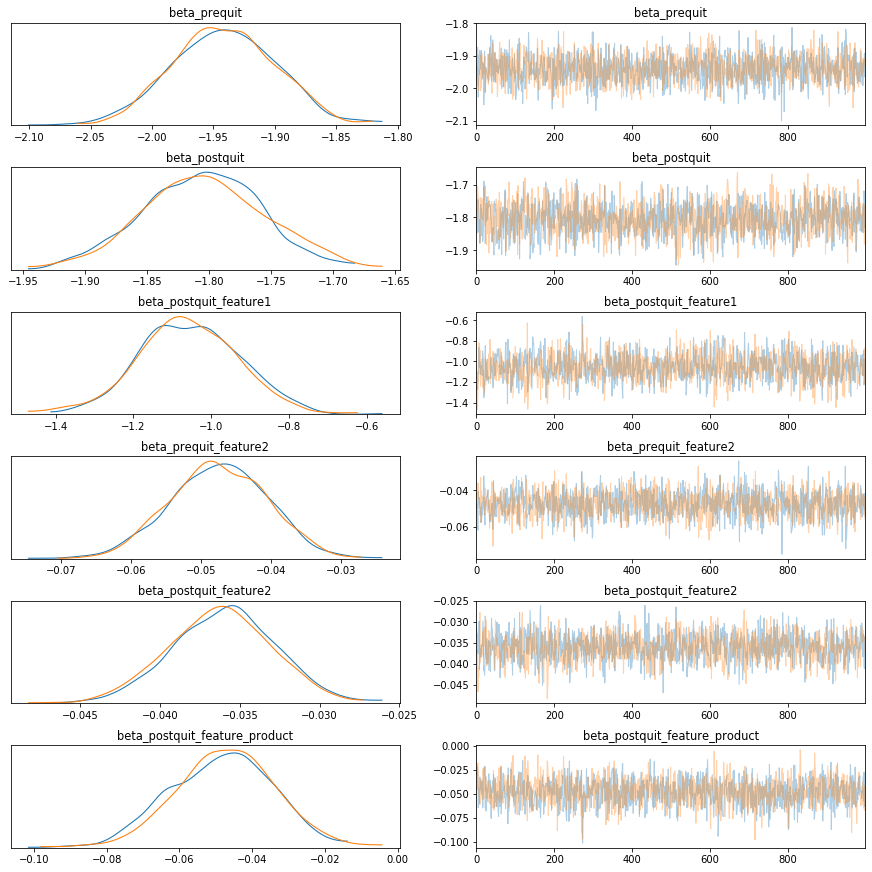

In [21]:
pm.traceplot(posterior_samples)

In [22]:
# Remove variable from workspace
del model, posterior_samples, model_summary_logscale

## Model 4

In [23]:
feature1 = order_within_day

In [24]:
with pm.Model() as model:
    # -------------------------------------------------------------------------
    # Priors
    # -------------------------------------------------------------------------
    beta_prequit = pm.Normal('beta_prequit', mu=0, sd=10)
    beta_postquit = pm.Normal('beta_postquit', mu=0, sd=10)
    beta_prequit_feature1 = pm.Normal('beta_prequit_feature1', mu=0, sd=10)
    beta_postquit_feature1 = pm.Normal('beta_postquit_feature1', mu=0, sd=10)


    # -------------------------------------------------------------------------
    # Likelihood
    # -------------------------------------------------------------------------
    loglamb_observed = (
        beta_prequit*(1-is_post_quit[~censored]) + beta_postquit*is_post_quit[~censored]
        )

    loglamb_observed_features = (
        beta_prequit_feature1*feature1[~censored]*(1-is_post_quit[~censored]) +
        beta_postquit_feature1*feature1[~censored]*is_post_quit[~censored]
    )

    lamb_observed = np.exp(loglamb_observed + loglamb_observed_features)

    Y_hat_observed = pm.Exponential('Y_hat_observed', lam = lamb_observed, observed=time_to_next_event[~censored])

    loglamb_censored = (
        beta_prequit*(1-is_post_quit[censored]) + beta_postquit*is_post_quit[censored]
    )
    
    loglamb_censored_features = (
        beta_prequit_feature1*feature1[censored]*(1-is_post_quit[censored]) +
        beta_postquit_feature1*feature1[censored]*is_post_quit[censored]
    )

    lamb_censored = np.exp(loglamb_censored + loglamb_censored_features)

    Y_hat_censored = pm.Potential('Y_hat_censored', exponential_log_complementary_cdf(x = time_to_next_event[censored], lam = lamb_censored))

#%%
# Sample from posterior distribution
with model:
    posterior_samples = pm.sample(draws=1000, tune=1000, cores=1, init='adapt_diag', target_accept=0.90, max_treedepth=50)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_postquit_feature1, beta_prequit_feature1, beta_postquit, beta_prequit]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 516.14it/s]


In [25]:
model_summary_logscale = az.summary(posterior_samples, credible_interval=.95)
model_summary_logscale = model_summary_logscale[['mean','hpd_2.5%','hpd_97.5%']]
model_summary_logscale

,mean,hpd_2.5%,hpd_97.5%
beta_prequit,-2.339,-2.446,-2.229
beta_postquit,-3.170,-3.258,-3.082
beta_prequit_feature1,0.041,0.023,0.060
beta_postquit_feature1,0.107,0.101,0.113


In [26]:
posterior_samples_expscale_prequit_feature1 = np.exp(posterior_samples['beta_prequit_feature1'])
posterior_samples_expscale_postquit_feature1 = np.exp(posterior_samples['beta_postquit_feature1'])

model_summary_expscale = {'mean': [np.mean(posterior_samples_expscale_prequit_feature1), np.mean(posterior_samples_expscale_postquit_feature1)],
                          'LB': [np.quantile(posterior_samples_expscale_prequit_feature1, q=.125), np.quantile(posterior_samples_expscale_postquit_feature1, q=.125)],
                          'UB': [np.quantile(posterior_samples_expscale_prequit_feature1, q=.975), np.quantile(posterior_samples_expscale_postquit_feature1, q=.975)]}

model_summary_expscale = pd.DataFrame(model_summary_expscale)
model_summary_expscale.index = ['exp_beta_prequit_feature1', 'exp_beta_postquit_feature1']
model_summary_expscale

,mean,LB,UB
exp_beta_prequit_feature1,1.041807,1.030385,1.060477
exp_beta_postquit_feature1,1.112658,1.108405,1.119749


In [27]:
# Difference between pre-quit and post-quit periods:
# time to first self-report
diff_prepost_feature1 = posterior_samples['beta_postquit_feature1'] - posterior_samples['beta_prequit_feature1']
exp_diff_prepost_feature1 = np.exp(diff_prepost_feature1)

diff_summary_expscale = {'mean': [np.mean(exp_diff_prepost_feature1)],
                          'LB': [np.quantile(exp_diff_prepost_feature1, q=.125)],
                          'UB': [np.quantile(exp_diff_prepost_feature1, q=.975)]}

diff_summary_expscale = pd.DataFrame(diff_summary_expscale)
diff_summary_expscale.index = ['exp_diff_prepost_feature1']
diff_summary_expscale

,mean,LB,UB
exp_diff_prepost_feature1,1.068103,1.056175,1.089849


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002177E797FC8>,
      dtype=object)

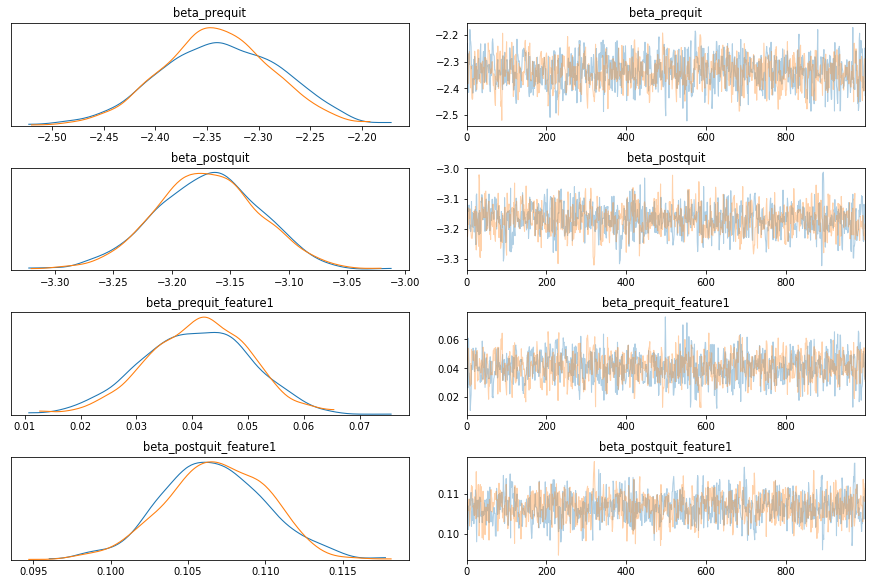

In [28]:
pm.traceplot(posterior_samples)

## Model 5

In [29]:
feature1 = is_within48hours_quit
feature2 = order_within_day

In [30]:
with pm.Model() as model:
    # -------------------------------------------------------------------------
    # Priors
    # -------------------------------------------------------------------------
    beta_prequit = pm.Normal('beta_prequit', mu=0, sd=10)
    beta_postquit = pm.Normal('beta_postquit', mu=0, sd=10)
    beta_postquit_feature1 = pm.Normal('beta_postquit_feature1', mu=0, sd=10)
    beta_prequit_feature2 = pm.Normal('beta_prequit_feature2', mu=0, sd=10)
    beta_postquit_feature2 = pm.Normal('beta_postquit_feature2', mu=0, sd=10)
    beta_postquit_feature_product = pm.Normal('beta_postquit_feature_product', mu=0, sd=10)

    # -------------------------------------------------------------------------
    # Likelihood
    # -------------------------------------------------------------------------
    loglamb_observed = (
        beta_prequit*(1-is_post_quit[~censored]) + beta_postquit*is_post_quit[~censored] 
        )

    loglamb_observed_features1 = (
        beta_postquit_feature1*feature1[~censored]*is_post_quit[~censored] +
        beta_prequit_feature2*feature2[~censored]*(1-is_post_quit[~censored]) +
        beta_postquit_feature2*feature2[~censored]*is_post_quit[~censored] +
        beta_postquit_feature_product*feature1[~censored]*feature2[~censored]*is_post_quit[~censored]
    )

    lamb_observed = np.exp(loglamb_observed + loglamb_observed_features1)

    Y_hat_observed = pm.Exponential('Y_hat_observed', lam = lamb_observed, observed=time_to_next_event[~censored])

    loglamb_censored = (
        beta_prequit*(1-is_post_quit[censored]) + beta_postquit*is_post_quit[censored] 
    )
    
    loglamb_censored_features1 = (
        beta_postquit_feature1*feature1[censored]*is_post_quit[censored] +
        beta_prequit_feature2*feature2[censored]*(1-is_post_quit[censored]) +
        beta_postquit_feature2*feature2[censored]*is_post_quit[censored] +
        beta_postquit_feature_product*feature1[censored]*feature2[censored]*is_post_quit[censored]
    )

    lamb_censored = np.exp(loglamb_censored + loglamb_censored_features1)

    Y_hat_censored = pm.Potential('Y_hat_censored', exponential_log_complementary_cdf(x = time_to_next_event[censored], lam = lamb_censored))

with model:
    posterior_samples = pm.sample(draws=1000, tune=1000, cores=1, init='adapt_diag', target_accept=0.90, max_treedepth=50)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_postquit_feature_product, beta_postquit_feature2, beta_prequit_feature2, beta_postquit_feature1, beta_postquit, beta_prequit]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:05<00:00, 395.14it/s]


In [31]:
model_summary_logscale = az.summary(posterior_samples, credible_interval=.95)
model_summary_logscale = model_summary_logscale[['mean','hpd_2.5%','hpd_97.5%']]
model_summary_logscale

,mean,hpd_2.5%,hpd_97.5%
beta_prequit,-2.339,-2.443,-2.232
beta_postquit,-2.771,-2.877,-2.679
beta_postquit_feature1,-1.335,-1.567,-1.094
beta_prequit_feature2,0.041,0.023,0.059
beta_postquit_feature2,0.093,0.086,0.100
beta_postquit_feature_product,0.090,0.052,0.125


In [32]:
posterior_samples_expscale_postquit_feature1 = np.exp(posterior_samples['beta_postquit_feature1'])
posterior_samples_expscale_prequit_feature2 = np.exp(posterior_samples['beta_prequit_feature2'])
posterior_samples_expscale_postquit_feature2 = np.exp(posterior_samples['beta_postquit_feature2'])
posterior_samples_expscale_postquit_feature_product = np.exp(posterior_samples['beta_postquit_feature_product'])

model_summary_expscale = {'mean': [np.mean(posterior_samples_expscale_postquit_feature1), 
                                   np.mean(posterior_samples_expscale_prequit_feature2), 
                                   np.mean(posterior_samples_expscale_postquit_feature2), 
                                   np.mean(posterior_samples_expscale_postquit_feature_product)],
                          'LB': [np.quantile(posterior_samples_expscale_postquit_feature1, q=.125), 
                                 np.quantile(posterior_samples_expscale_prequit_feature2, q=.125), 
                                 np.quantile(posterior_samples_expscale_postquit_feature2, q=.125),
                                 np.quantile(posterior_samples_expscale_postquit_feature_product, q=.125)],
                          'UB': [np.quantile(posterior_samples_expscale_postquit_feature1, q=.975), 
                                 np.quantile(posterior_samples_expscale_prequit_feature2, q=.975), 
                                 np.quantile(posterior_samples_expscale_postquit_feature2, q=.975),
                                 np.quantile(posterior_samples_expscale_postquit_feature_product, q=.975)]}

model_summary_expscale = pd.DataFrame(model_summary_expscale)
model_summary_expscale.index = ['exp_beta_postquit_feature1','exp_beta_prequit_feature2', 'exp_beta_postquit_feature2','exp_beta_postquit_feature_product']
model_summary_expscale

,mean,LB,UB
exp_beta_postquit_feature1,0.265214,0.228354,0.333343
exp_beta_prequit_feature2,1.041942,1.030495,1.060703
exp_beta_postquit_feature2,1.097123,1.092820,1.104398
exp_beta_postquit_feature_product,1.093875,1.068885,1.132018


In [33]:
# Time to first self-report within period:

# Difference between within first 48 hours in post-quit period vs. after first 48 hours in post-quit period
diff_feature_postquitwithin48_postquitafter48 = posterior_samples['beta_postquit_feature_product']
exp_diff_feature_postquitwithin48_postquitafter48 = np.exp(diff_feature_postquitwithin48_postquitafter48)

# Difference between within first 48 hours in post-quit period vs. pre-quit
diff_feature_postquitwithin48_prequit = posterior_samples['beta_postquit_feature2'] + posterior_samples['beta_postquit_feature_product'] - posterior_samples['beta_prequit_feature2']
exp_diff_feature_postquitwithin48_prequit = np.exp(diff_feature_postquitwithin48_prequit)

# Difference between after 48 hours in post-quit period vs. pre-quit
diff_feature_postquitafter48_prequit = posterior_samples['beta_postquit_feature2'] - posterior_samples['beta_prequit_feature2']
exp_diff_feature_postquitafter48_prequit = np.exp(diff_feature_postquitafter48_prequit)

diff_summary_expscale = {'mean': [np.mean(exp_diff_feature_postquitwithin48_postquitafter48), np.mean(exp_diff_feature_postquitwithin48_prequit), np.mean(exp_diff_feature_postquitafter48_prequit)],
                          'LB': [np.quantile(exp_diff_feature_postquitwithin48_postquitafter48, q=.125), np.quantile(exp_diff_feature_postquitwithin48_prequit, q=.125), np.quantile(exp_diff_feature_postquitafter48_prequit, q=.125)],
                          'UB': [np.quantile(exp_diff_feature_postquitwithin48_postquitafter48, q=.975), np.quantile(exp_diff_feature_postquitwithin48_prequit, q=.975), np.quantile(exp_diff_feature_postquitafter48_prequit, q=.975)]}

diff_summary_expscale = pd.DataFrame(diff_summary_expscale)
diff_summary_expscale.index = ['exp_diff_feature_postquitwithin48_postquitafter48','exp_diff_feature_postquitwithin48_prequit','exp_diff_feature_postquitafter48_prequit']
diff_summary_expscale

,mean,LB,UB
exp_diff_feature_postquitwithin48_postquitafter48,1.093875,1.068885,1.132018
exp_diff_feature_postquitwithin48_prequit,1.151900,1.123689,1.198687
exp_diff_feature_postquitafter48_prequit,1.053054,1.041117,1.074453


In [34]:
# Remove variable from workspace
del model, posterior_samples, model_summary_logscale